Load Glutamatergic Data

In [2]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
import scanpy.external as sce
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
random.seed(66)

data_path = "E:/Opossum_M1/"

sample_IDs = ["NW_TX0055-4_S01_L003-001", "NW_TX0055-5_S01_L003-001", "NW_TX0055-6_S01_L003-001", "NW_TX0064-3_S01_L003-001", 
              "NW_TX0064-4_S01_L003-001", "NW_TX0064-5_S01_L003-001", "NW_TX0077-7_S01_L003-001", "NW_TX0077-8_S01_L003-001", 
              "NW_TX0078-1_S01_L003-001", "NW_TX0090-11_S01_L003-001", "NW_TX0092-7_S01_L003-001", "NW_TX0092-8_S01_L003-001"]

adata = sc.read_h5ad(data_path + "Opossum_M1_Glut.h5ad")
adata

AnnData object with n_obs × n_vars = 82236 × 18827
    obs: 'batch', 'species', 'n_genes', 'n_counts', 'leiden', 'doublet', 'doublet_score', 'class'
    var: 'gene_ids', 'feature_types', 'genome'

In [3]:
adata.X = adata.raw.X

Analyze Glutamatergic Cells

In [4]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)


2023-05-25 15:20:39,872 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-05-25 15:21:01,844 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-05-25 15:21:02,465 - harmonypy - INFO - Iteration 1 of 20
2023-05-25 15:21:50,030 - harmonypy - INFO - Iteration 2 of 20
2023-05-25 15:22:37,552 - harmonypy - INFO - Iteration 3 of 20
2023-05-25 15:23:25,304 - harmonypy - INFO - Converged after 3 iterations


computing neighbors


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:41)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:10)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


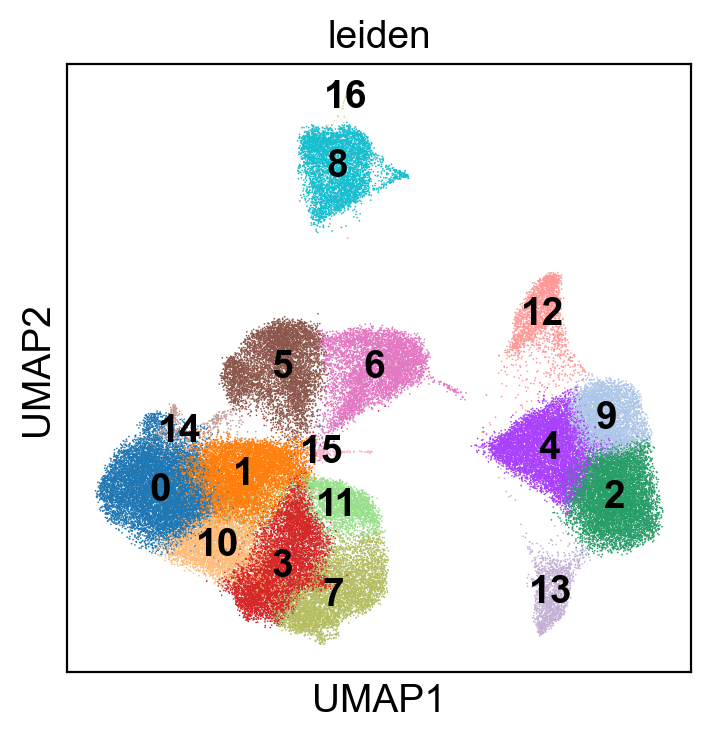

In [5]:
sc.tl.pca(adata, svd_solver="arpack")
sce.pp.harmony_integrate(adata, "batch", max_iter_harmony=20, random_state=66)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


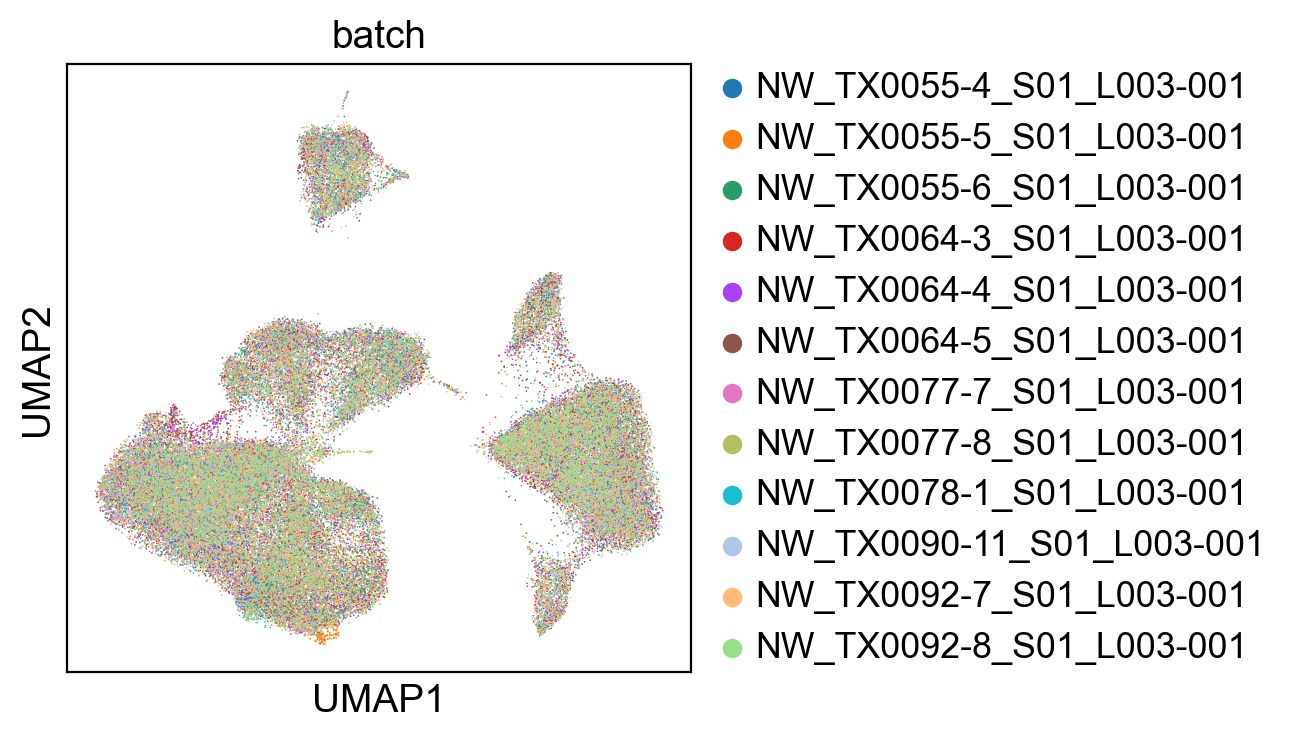

In [6]:
sc.pl.umap(adata, color=["batch"])

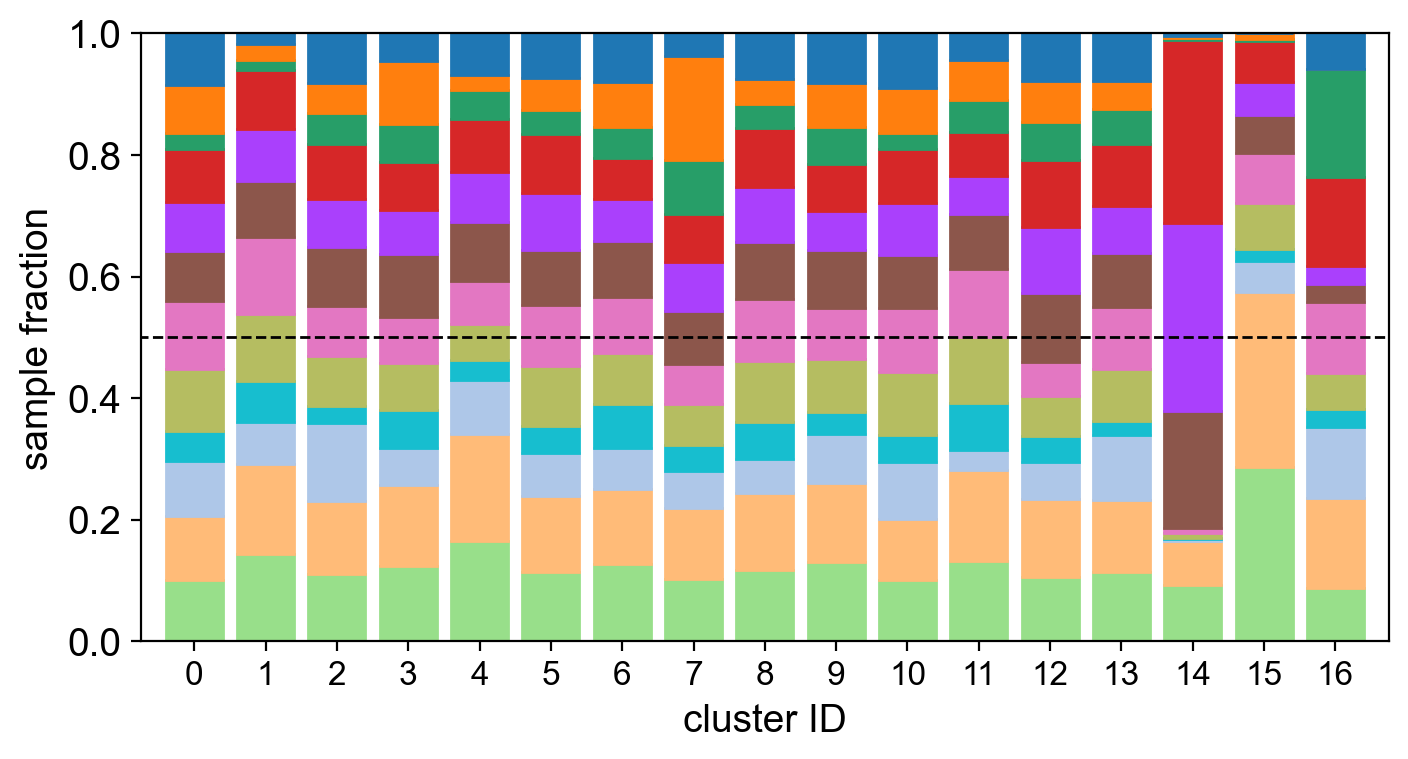

In [7]:
cluster_ids = sorted(np.unique(adata.obs["leiden"]).astype(int))
sample_fractions = []
for sample in sample_IDs[::-1]:
    sf = []
    for cluster in cluster_ids:
        adata_clust = adata[adata.obs["leiden"] == str(cluster), :]
        sf.append(np.sum(adata_clust.obs["batch"] == sample) / adata_clust.shape[0])
    sample_fractions.append(sf)

fig, ax = plt.subplots()
bottom = np.zeros(len(cluster_ids))
for sf, col in zip(sample_fractions, adata.uns["batch_colors"][::-1]):
    ax.bar(cluster_ids, sf, color=col, edgecolor=col, bottom=bottom)
    bottom += np.array(sf)
ax.hlines(0.5, -1, np.max(cluster_ids) + 1, color="k", linestyle="--", linewidth=1)
ax.set_xlabel("cluster ID")
ax.set_xlim((-0.75, np.max(cluster_ids) + 0.75))
ax.set_xticks(cluster_ids)
ax.set_xticklabels(cluster_ids, fontsize=12)
ax.set_ylabel("sample fraction")
ax.set_ylim((0, 1))
ax.grid(False)
fig.set_size_inches(8, 4)
plt.show(block=False)

In [8]:
# Remove clusters if they arise from a single sample.
sample_cluster_ids = [14, 15, 16]
cluster_ids = sorted(np.unique(adata.obs["leiden"]).astype(int))
for cluster in cluster_ids:
    if cluster in sample_cluster_ids:
        cluster_mask = adata.obs["leiden"] != str(cluster)
        adata = adata[cluster_mask, :]

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


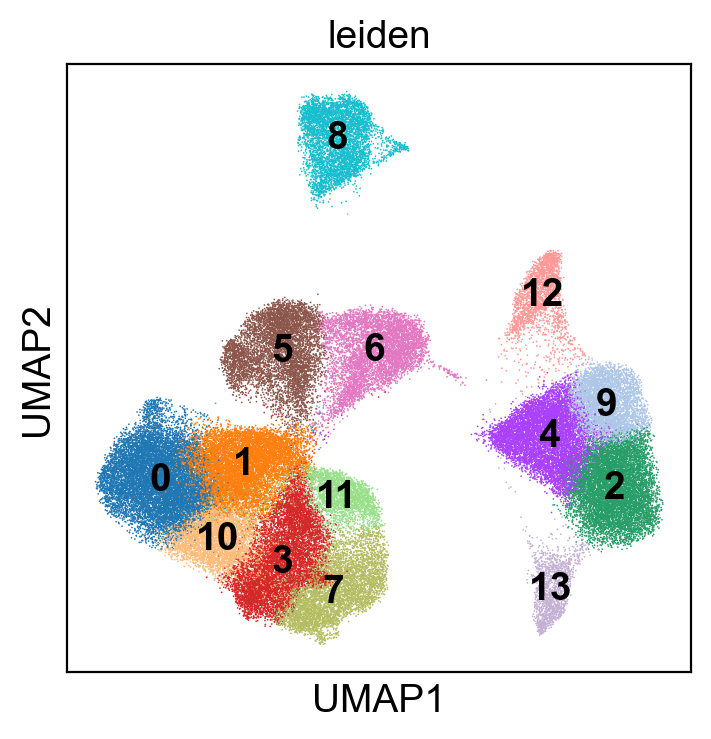

In [9]:
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Ryan\GitHub\scanpy\scanpy\tools\_dendrogram.py:161: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat


categories: 0, 1, 2, etc.
var_group_labels: General, 2/3, 234, etc.


C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


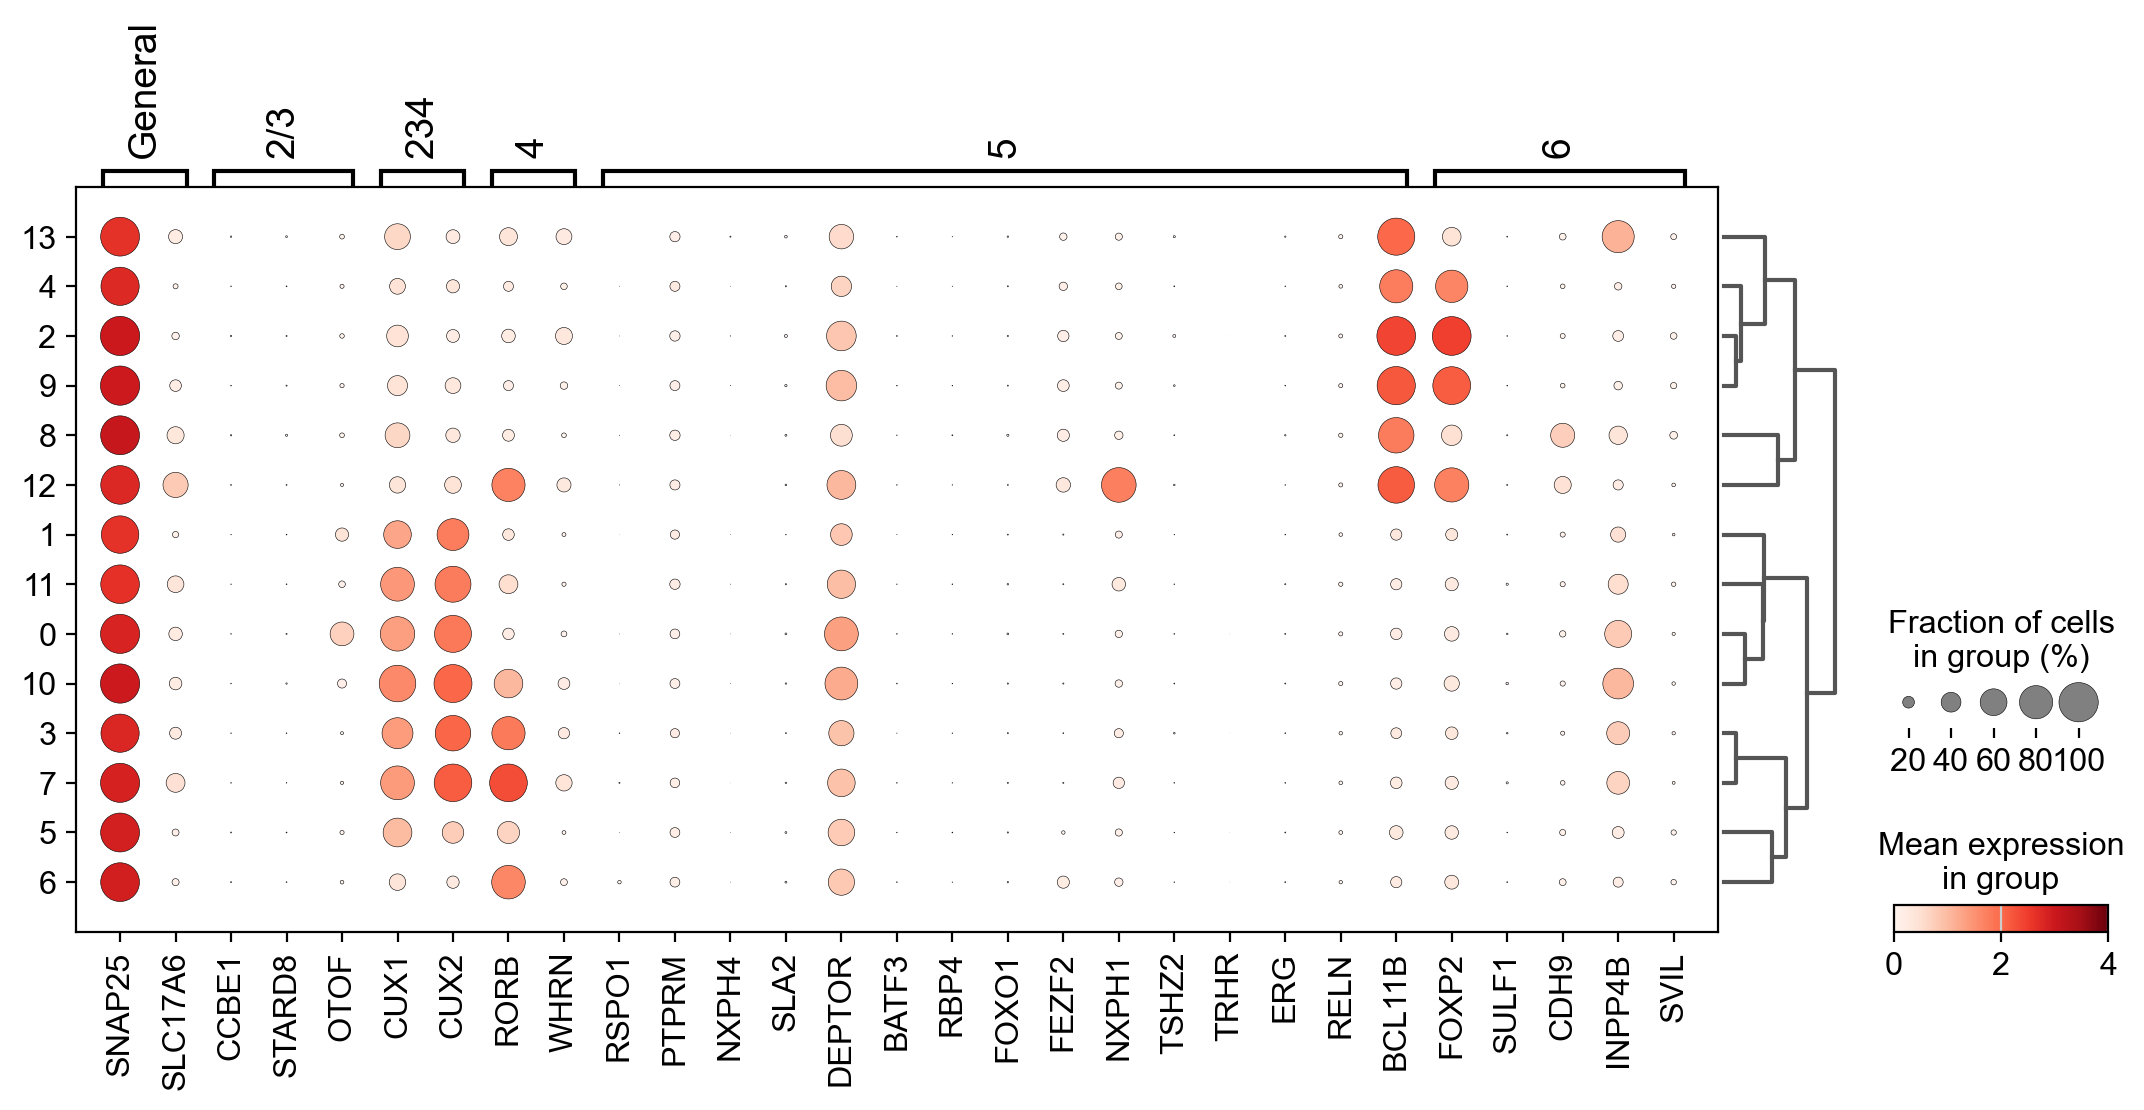

In [10]:
glutamatergic_markers = [
                         "SNAP25", "SLC17A6", # general
                         "CCBE1", "STARD8", "OTOF", # L2/3
                         "CUX1", "CUX2", # L2/3 & L4
                         "RORB", "WHRN", "RSPO1", # L4
                         "PTPRM", "NXPH4", "SLA2", 
                         "DEPTOR", "BATF3", "RBP4", "FOXO1", "FEZF2", "NXPH1", "TSHZ2", "TRHR", "ERG", "RELN", "BCL11B", # L5
                         "FOXP2", "SULF1", "CDH9", "INPP4B", "SVIL" # L6
                        ]

sc.pl.dotplot(
    adata, 
    glutamatergic_markers, 
    groupby="leiden", 
    dendrogram=True, 
    swap_axes=False, 
    vmin=0, vmax=4, 
    var_group_positions=[(0, 1), (2, 4), (5, 6), (7, 8), (9, 23), (24, 28)], 
    var_group_labels=["General", "2/3", "234", "4", "5", "6"], 
            )

Save Clustered AnnData Object

In [11]:
adata.write_h5ad(data_path + "Opossum_M1_Glut_Clustered.h5ad")

Find Marker Genes for Clusters Among Subclasses

In [4]:
import pandas as pd
from ast import literal_eval

results = pd.read_csv("E:/glut_0to5_10000_15_10_6.csv").drop("Unnamed: 0", axis=1)
results["clusterName"] = results["clusterName"].astype(str)
results["NSForest_markers"] = results["NSForest_markers"].apply(literal_eval)
results["binary_genes"] = results["binary_genes"].apply(literal_eval)
results

,clusterName,clusterSize,f_score,PPV,TN,FP,FN,TP,marker_count,NSForest_markers,binary_genes
0,0,8515,0.598792,0.678397,69882,1645,5045,3470,3,"[SPATS2L, SLC24A4, CHST9]","[OTOF, CEMIP, ACVR1C, SPATS2L, SLC24A4, CHST9,..."
1,1,8313,0.643198,0.679969,69660,2069,3917,4396,4,"[GRM8, FOXP2, NRP1, BCL11B]","[GRM8, FOXP2, CNTNAP4, NRP1, TENM1, BCL11B, C8..."
2,2,7747,0.460925,0.549129,70510,1785,5573,2174,2,"[EPHB6, TENM1]","[EPHB6, FOXP2, CNTNAP4, TENM1, FSTL5, BCL11B, ..."
3,3,7530,0.455114,0.503457,70070,2442,5054,2476,2,"[ENSMODG00000016171, ENSMODG00000015456]","[CUX2, ENSMODG00000002350, ENSMODG00000016171,..."
4,4,7286,0.411412,0.423023,69072,3684,4585,2701,4,"[TRPM3, COL19A1, COL5A1, SLIT3]","[GUCY1A1, CHST9, TRPM3, COL19A1, COL5A1, SLIT3..."


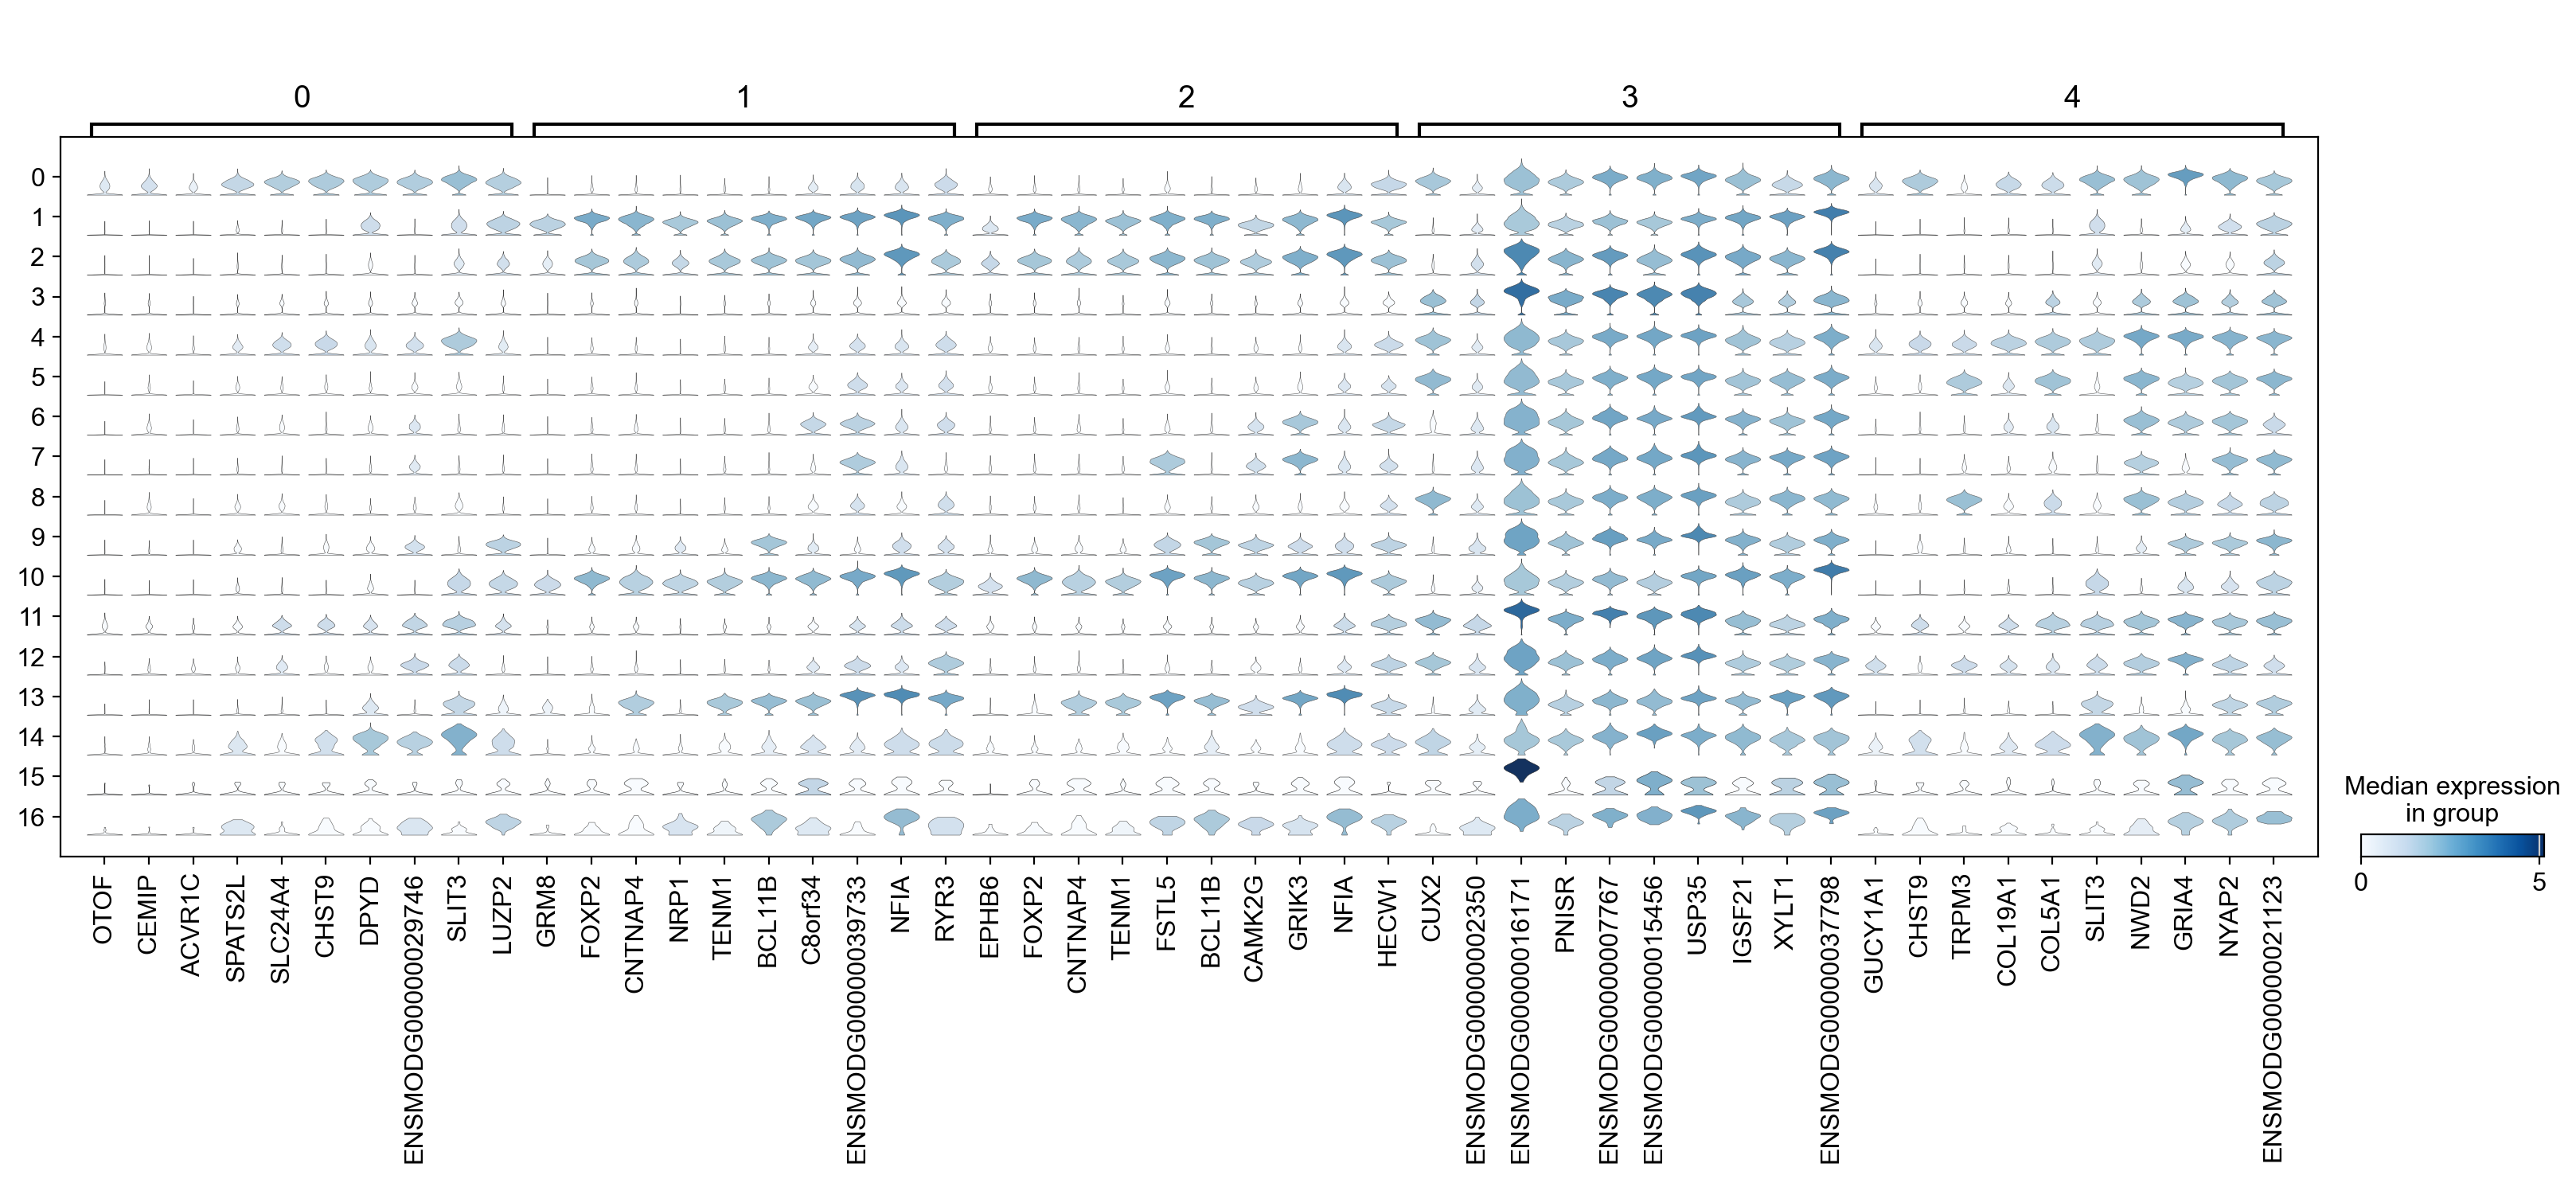

In [5]:
markers = dict(zip(results['clusterName'], results['binary_genes']))
sc.pl.stacked_violin(adata, markers, groupby="leiden", swap_axes=False)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


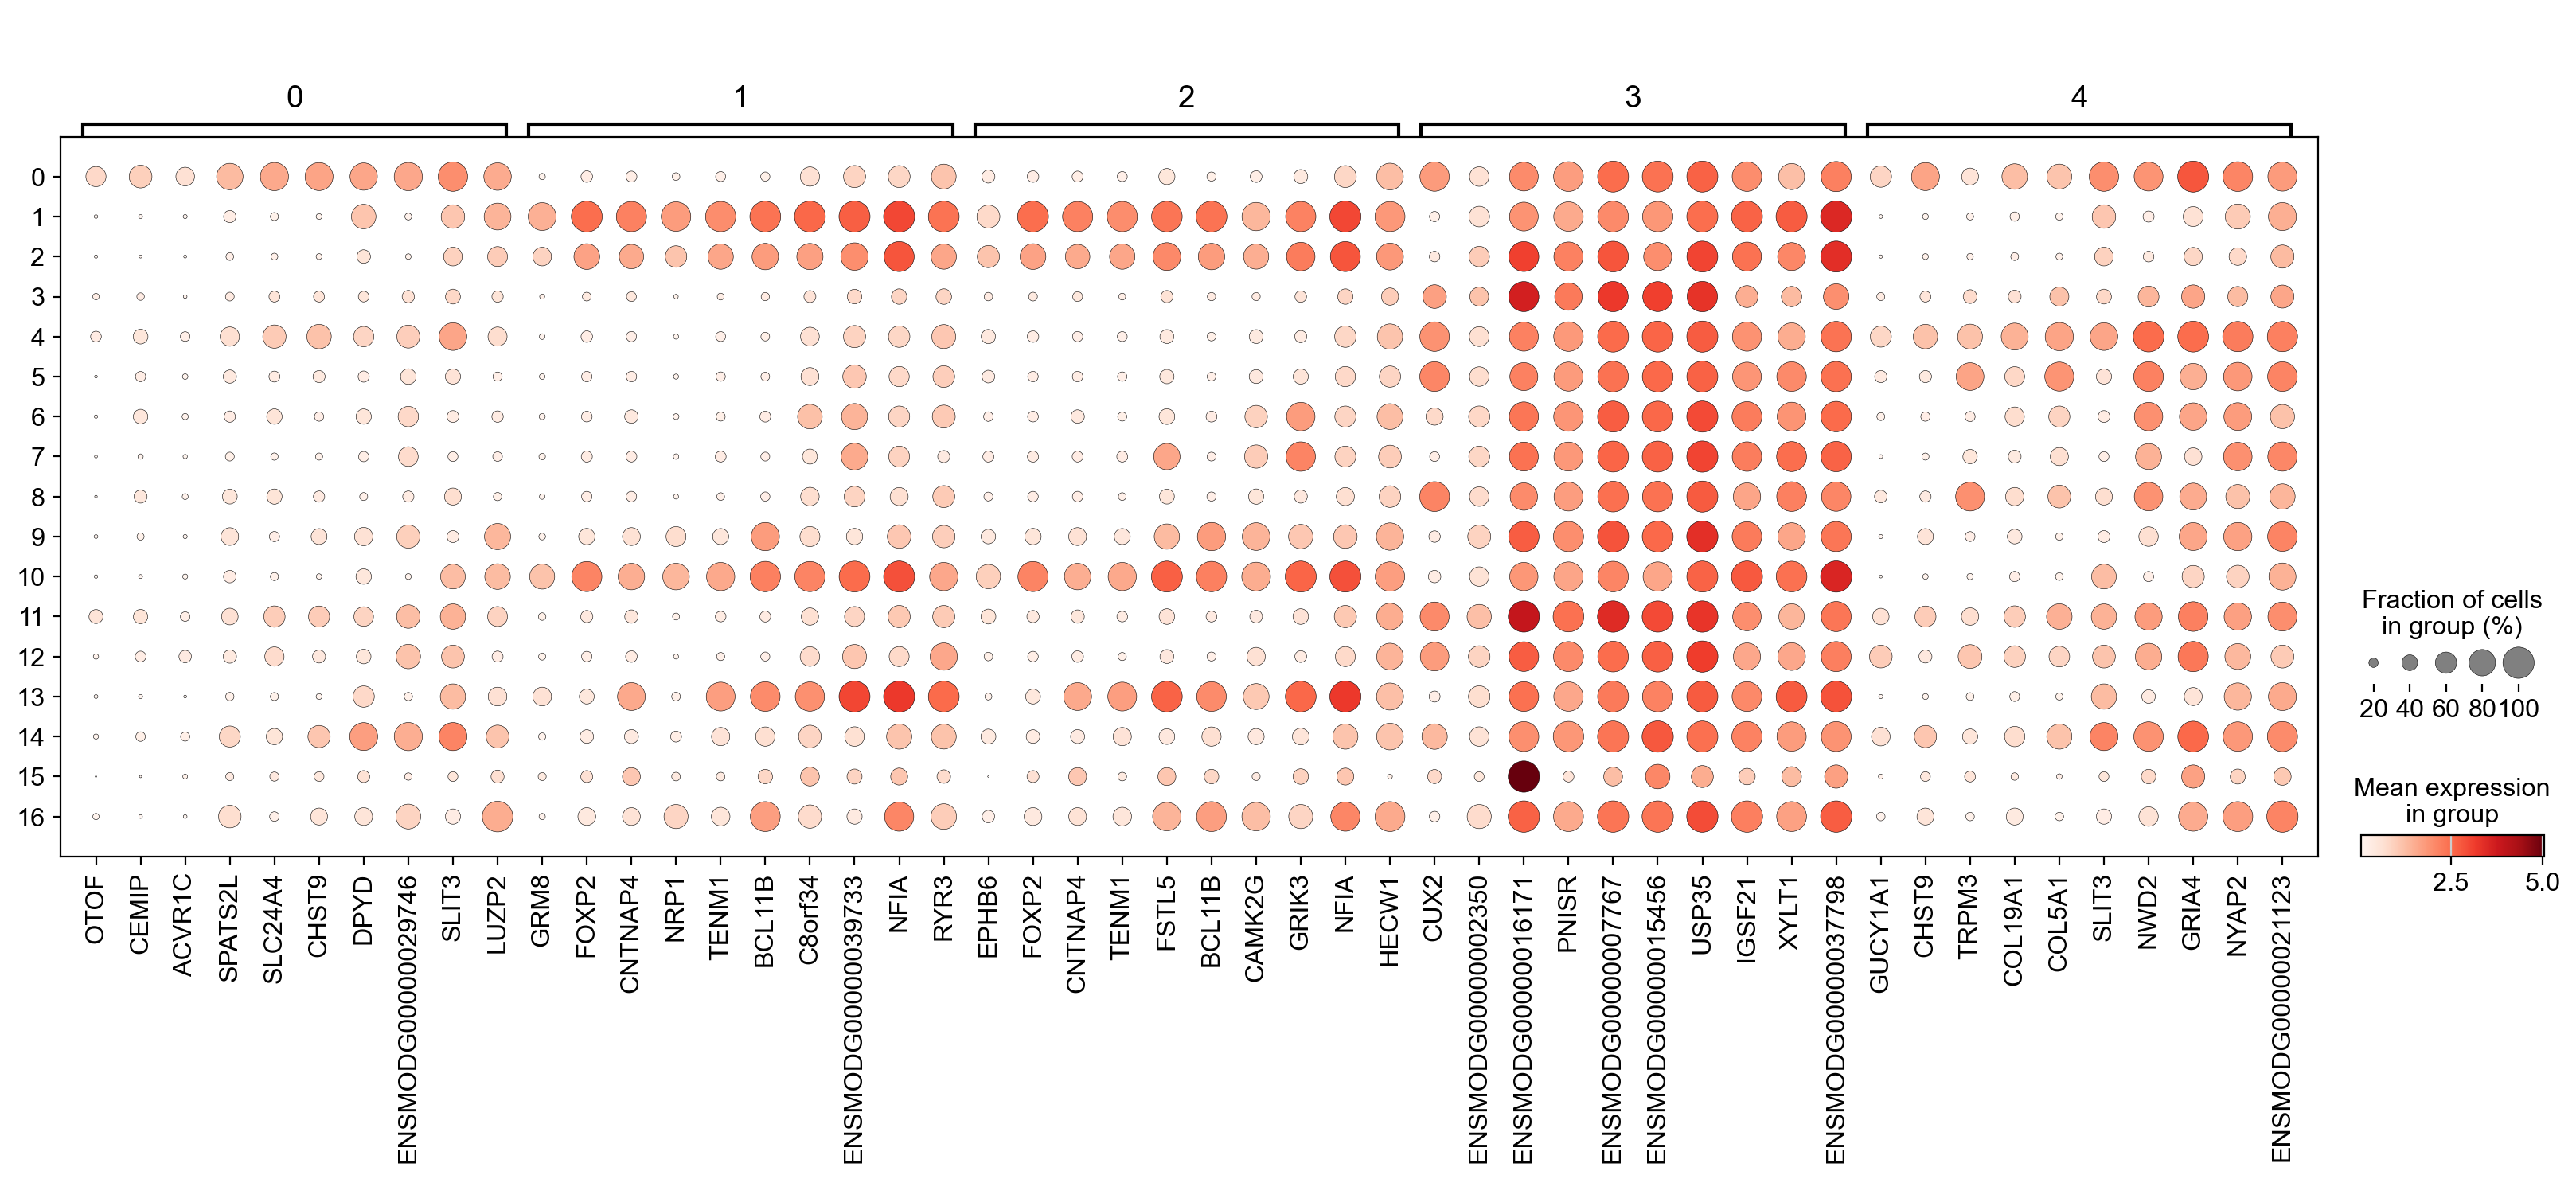

In [7]:
sc.pl.dotplot(adata, markers, groupby="leiden", swap_axes=False)